In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import seaborn as sns
from matplotlib.dates import  DateFormatter
%matplotlib inline
from ebmdatalab import bq
from ebmdatalab import charts
from ebmdatalab import maps

Here's some text about what we need to do.

### Import data from BigQuery

In [4]:
sql = """
  -- First we create a temp table with aggregated data for each bnf_code and month,
  -- which signficantly reduces runtime for the main query

CREATE TEMP TABLE price_concessions_quantity AS
SELECT
  month AS month,
  rx.bnf_code AS bnf_code,
  RTRIM(bnf_name) AS bnf_name,
  SUM(quantity) AS quantity,
  SUM(actual_cost) AS actual_cost,
  AVG(SUM(quantity)) OVER (PARTITION BY rx.bnf_code ORDER BY month ROWS BETWEEN 2 PRECEDING AND CURRENT ROW) AS rolling_ave_quantity -- this creates a 3 month rolling average of quantity
FROM
  hscic.normalised_prescribing AS rx
INNER JOIN (
  SELECT
    bnf_code
  FROM
    dmd.ncsoconcession AS ncso
  INNER JOIN
    dmd.vmpp AS vmpp
  ON
    vmpp.id=ncso.vmpp
  GROUP BY
    bnf_code) AS ncso
ON
  ncso.bnf_code = rx.bnf_code
GROUP BY
  month,
  rx.bnf_code,
  bnf_name
ORDER BY
  bnf_code,
  month ;
  
  --this is the main query
  
SELECT
  DATE(rx.month) AS rx_month,
  vmpp.bnf_code AS bnf_code,
  vmpp.nm AS product_name,
  SUM(rx.quantity) AS quantity,
  SUM(rx.rolling_ave_quantity) AS rolling_ave_quantity,
  dt.price_pence AS dt_price_pence,
  ncso.price_pence AS ncso_price_pence,
  
  SUM((dt.price_pence * 
       rx_item.quantity *
          -- This uses quantity from 2 months prior to the prescribing month.
          -- This is the data available at the time of the price concession announcement,
          -- so we use this to predict.

      --vmpp.bnf_code IN ('0206010F0AACJCJ', '1202010U0AAAAAA') THEN 1
      --ELSE
      1 / vmpp.qtyval
      --END
      -- This is the "discount factor" which applies the National Average 7.2%
      -- discount to estimate Actual Cost from Net Ingredient Cost and also
      -- converts figures from pence to pounds
      * 0.00928)+ (COALESCE(ncso.price_pence - dt.price_pence,
        0) * rx_item.quantity *
      --CASE
      --  WHEN vmpp.bnf_code IN ('0206010F0AACJCJ', '1202010U0AAAAAA') THEN 1
      --ELSE
      1 / vmpp.qtyval
      --END
      * 0.00928)) AS predicted_cost,
  SUM((dt.price_pence * rx_item.rolling_ave_quantity * -- this is using 3 months rolling quantity average
      --CASE
      --  WHEN vmpp.bnf_code IN ('0206010F0AACJCJ', '1202010U0AAAAAA') THEN 1
      --ELSE
      1 / vmpp.qtyval
    --END
      * 0.00928)+ (COALESCE(ncso.price_pence - dt.price_pence,
        0) * rx_item.rolling_ave_quantity *
      --CASE
        --WHEN vmpp.bnf_code IN ('0206010F0AACJCJ', '1202010U0AAAAAA') THEN 1
      --ELSE
      1 / vmpp.qtyval
    --END
      * 0.00928)) AS predicted_cost_rolling,
  SUM(rx.actual_cost) AS actual_cost
FROM
  dmd.tariffprice AS dt
RIGHT JOIN
  dmd.ncsoconcession AS ncso
ON
  ncso.vmpp = dt.vmpp
  AND ncso.date = dt.date
INNER JOIN
  dmd.vmpp AS vmpp
ON
  vmpp.id=ncso.vmpp
INNER JOIN
  price_concessions_quantity AS rx --this is joining to the temp table, creating the current month actual_cost
ON
  rx.bnf_code = vmpp.bnf_code
  AND rx.month = TIMESTAMP(ncso.date)
INNER JOIN
  price_concessions_quantity AS rx_item --this is joining to the temp table, with a 2 month difference to calculate predicted quantities
ON
  rx_item.bnf_code = vmpp.bnf_code
  AND rx_item.month = TIMESTAMP(DATE_ADD(ncso.date, INTERVAL -2 month))
WHERE
  rx.month >='2017-01-01'
GROUP BY
  rx.month,
  vmpp.bnf_code,
  vmpp.nm,
  dt.price_pence,
  ncso.price_pence,
  TIMESTAMP(DATE_ADD(ncso.date, INTERVAL -2 month))
ORDER BY
  vmpp.bnf_code, 
  rx.month
"""

exportfile = os.path.join("..","data","ncso_df.csv")
ncso_df = bq.cached_read(sql, csv_path=exportfile, use_cache=False)
ncso_df["predicted_cost"] = pd.to_numeric(ncso_df["predicted_cost"])
ncso_df['rx_month'] = ncso_df['rx_month'].astype('datetime64[ns]')

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=725825577420-unm2gnkiprugilg743tkbig250f4sfsj.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fbigquery&state=sseWZdoP5GGzxGgyVMJQnbOrVDNTcB&prompt=consent&access_type=offline


Enter the authorization code:  4/2QGhuqlRbgW2h0JMCkxsZV13nWvchS9J0_7rBaM1wjikgThbboRWdcQ


Downloading: 100%|██████████| 2380/2380 [00:00<00:00, 4273.02rows/s]


In [5]:
ncso_sum_df=ncso_df.groupby(['rx_month',])[['quantity','rolling_ave_quantity','predicted_cost','predicted_cost_rolling','actual_cost']].sum()  #group data to show total per month
ncso_sum_df['difference'] = ncso_sum_df['predicted_cost'] - ncso_sum_df['actual_cost']  #calculate difference between predicted and actual
ncso_sum_df['perc_difference'] = ncso_sum_df['difference'] / ncso_sum_df['actual_cost'] #calculate percentage difference
ncso_sum_df.sort_values(by=['rx_month']) #sort values by month for chart

,quantity,rolling_ave_quantity,predicted_cost,predicted_cost_rolling,actual_cost,difference,perc_difference
rx_month,,,,,,,
2017-01-01,34845972.0,3.574102e+07,8.137176e+06,8.039903e+06,8.005775e+06,1.314008e+05,0.016413
2017-02-01,32066632.0,3.418921e+07,8.383616e+06,8.093132e+06,7.423218e+06,9.603985e+05,0.129378
2017-03-01,35641955.0,3.318341e+07,8.067864e+06,8.297564e+06,8.696441e+06,-6.285765e+05,-0.072280
2017-04-01,31322530.0,3.247609e+07,6.166398e+06,6.610454e+06,6.301537e+06,-1.351393e+05,-0.021445
2017-05-01,34678515.0,3.425135e+07,1.361402e+07,1.263291e+07,1.235804e+07,1.255981e+06,0.101633
2017-06-01,39206231.0,3.695928e+07,2.856964e+07,2.990352e+07,3.250022e+07,-3.930588e+06,-0.120940
2017-07-01,44137873.5,4.468539e+07,3.519671e+07,3.464898e+07,3.566866e+07,-4.719582e+05,-0.013232
2017-08-01,108983792.0,1.071542e+08,4.734426e+07,4.480644e+07,4.660851e+07,7.357541e+05,0.015786
2017-09-01,270504489.5,2.698667e+08,5.836806e+07,5.898265e+07,5.813965e+07,2.284131e+05,0.003929


In [6]:
ncso_sum_df.reset_index(inplace=True)

Text(0.5, 1.0, 'Percentage difference between forecasted price concession costs and actual spend')

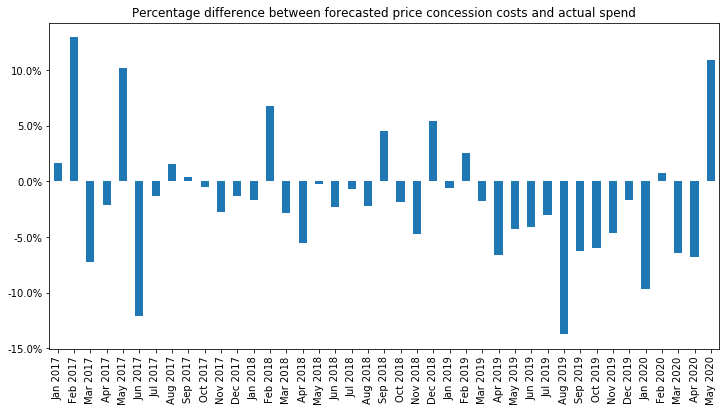

In [7]:
ax = ncso_sum_df.plot.bar(figsize = (12,6), y= ['perc_difference'], legend=None)
ax.xaxis.set_major_formatter(plt.FixedFormatter(ncso_sum_df['rx_month'].dt.strftime("%b %Y"))) #this formats date as string in desired format for x axis, formats here: https://www.ibm.com/support/knowledgecenter/SS6V3G_5.3.1/com.ibm.help.gswapplintug.doc/GSW_strdate.html
ax.yaxis.set_major_formatter(ticker.PercentFormatter(1, decimals=None)) ##sets y axis labels as percent (and formats correctly i.e. x100)
ax.set_title('Percentage difference between forecasted price concession costs and actual spend')

In [8]:
ncso_sum_df['perc_difference'].std()

0.05562811827581482

In [9]:
ncso_sum_df['difference_rolling'] = ncso_sum_df['predicted_cost_rolling'] - ncso_sum_df['actual_cost']  #calculate difference between 3 month average rolling predicted and actual
ncso_sum_df['perc_difference_rolling'] = ncso_sum_df['difference_rolling'] / ncso_sum_df['actual_cost'] #calculate percentage difference on 3 month rolling

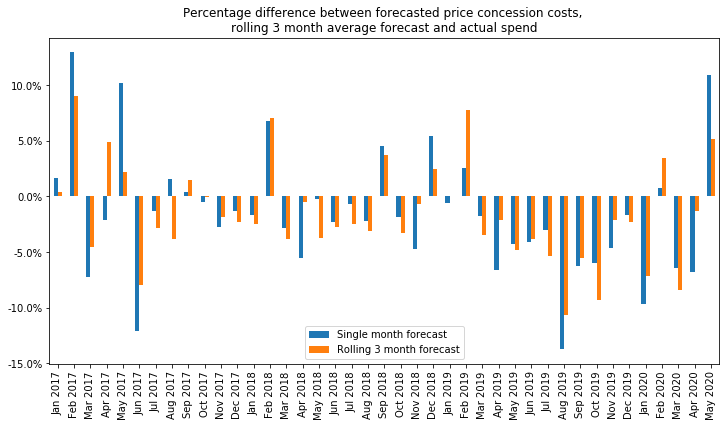

In [10]:
ax = ncso_sum_df.plot.bar(figsize = (12,6), y=['perc_difference', 'perc_difference_rolling'])
ax.xaxis.set_major_formatter(plt.FixedFormatter(ncso_sum_df['rx_month'].dt.strftime("%b %Y"))) #this formats date as string in desired format for x axis, formats here: https://www.ibm.com/support/knowledgecenter/SS6V3G_5.3.1/com.ibm.help.gswapplintug.doc/GSW_strdate.html
ax.yaxis.set_major_formatter(ticker.PercentFormatter(1, decimals=None)) ##sets y axis labels as percent (and formats correctly i.e. x100)
ax.set_title('Percentage difference between forecasted price concession costs, \nrolling 3 month average forecast and actual spend')
ax.legend(["Single month forecast", "Rolling 3 month forecast"])

### How could we get more accuracy?

In [15]:
# import bank holidays json (2012-2020)
#from pandas.io.json import json_normalize #package for flattening json in pandas df

In [16]:
# load bank holidays json and pass to busdays function `holidays=[]` ###
url = 'https://www.gov.uk/bank-holidays.json'
bh = pd.read_json(url, orient='index')
# separate out the embedded json 
#flattening json in pandas df
bh2 = pd.json_normalize(bh.iloc[0]["events"])
bh2.head()

,title,date,notes,bunting
0,New Year’s Day,2015-01-01,,True
1,Good Friday,2015-04-03,,False
2,Easter Monday,2015-04-06,,True
3,Early May bank holiday,2015-05-04,,True
4,Spring bank holiday,2015-05-25,,True


In [17]:
ncso_dates_df=ncso_sum_df.reset_index()

In [18]:
import calendar
dates = ncso_dates_df[["rx_month"]].drop_duplicates()
dates["rx_month"] = pd.to_datetime(dates["rx_month"])
dates["year"] = dates["rx_month"].dt.year
dates["mon"] = dates["rx_month"].dt.month
d = []
for row in dates.itertuples():
    y = row.year
    m = row.mon
    day = calendar.monthrange(y,m)[1]
    d.append(str(y)+"-"+str(m)+"-"+str(day))
d = pd.Series(d, name="enddates")
d = pd.to_datetime(d, format="%Y/%m/%d")
begindates = pd.Series(dates["rx_month"]).values.astype('datetime64[D]')
enddates = pd.Series(d).values.astype('datetime64[D]')
#######
# find business days in month
dates["bdays0"] = np.busday_count(begindates, enddates) # not excluding bank holidays
dates["bdays"] = np.busday_count(begindates, enddates, holidays=bh2["date"].values.astype('datetime64[D]'))
dates.head()

,rx_month,year,mon,bdays0,bdays
0,2017-01-01,2017,1,21,20
1,2017-02-01,2017,2,19,19
2,2017-03-01,2017,3,22,22
3,2017-04-01,2017,4,20,18
4,2017-05-01,2017,5,22,20


In [19]:
dates.set_index('rx_month')

,year,mon,bdays0,bdays
rx_month,,,,
2017-01-01,2017,1,21,20
2017-02-01,2017,2,19,19
2017-03-01,2017,3,22,22
2017-04-01,2017,4,20,18
2017-05-01,2017,5,22,20
2017-06-01,2017,6,21,21
2017-07-01,2017,7,20,20
2017-08-01,2017,8,22,21
2017-09-01,2017,9,21,21


In [20]:
ncso_sum_df.reset_index()

,index,rx_month,quantity,rolling_ave_quantity,predicted_cost,predicted_cost_rolling,actual_cost,difference,perc_difference,difference_rolling,perc_difference_rolling
0,0,2017-01-01,34845972.0,3.574102e+07,8.137176e+06,8.039903e+06,8.005775e+06,1.314008e+05,0.016413,3.412787e+04,0.004263
1,1,2017-02-01,32066632.0,3.418921e+07,8.383616e+06,8.093132e+06,7.423218e+06,9.603986e+05,0.129378,6.699147e+05,0.090246
2,2,2017-03-01,35641955.0,3.318341e+07,8.067864e+06,8.297564e+06,8.696441e+06,-6.285764e+05,-0.072280,-3.988772e+05,-0.045867
3,3,2017-04-01,31322530.0,3.247609e+07,6.166398e+06,6.610454e+06,6.301537e+06,-1.351393e+05,-0.021445,3.089166e+05,0.049022
4,4,2017-05-01,34678515.0,3.425135e+07,1.361402e+07,1.263291e+07,1.235804e+07,1.255981e+06,0.101633,2.748728e+05,0.022242
5,5,2017-06-01,39206231.0,3.695928e+07,2.856964e+07,2.990352e+07,3.250022e+07,-3.930588e+06,-0.120940,-2.596701e+06,-0.079898
6,6,2017-07-01,44137873.5,4.468539e+07,3.519671e+07,3.464898e+07,3.566866e+07,-4.719578e+05,-0.013232,-1.019685e+06,-0.028588
7,7,2017-08-01,108983792.0,1.071542e+08,4.734426e+07,4.480644e+07,4.660851e+07,7.357545e+05,0.015786,-1.802073e+06,-0.038664
8,8,2017-09-01,270504489.5,2.698667e+08,5.836806e+07,5.898265e+07,5.813965e+07,2.284136e+05,0.003929,8.429989e+05,0.014500
9,9,2017-10-01,403394513.5,3.999540e+08,7.101507e+07,7.136161e+07,7.140800e+07,-3.929232e+05,-0.005503,-4.638852e+04,-0.000650


In [21]:
ncso_sum_df = pd.merge(ncso_sum_df, dates, on='rx_month')

In [22]:
dates.index = pd.to_datetime(dates.index)

In [23]:
#dates['pred_month'] = dates.lookup(dates.index, dates['bdays'])
ncso_sum_df['bdays2']=ncso_sum_df['bdays'].shift(2)

In [24]:
ncso_sum_df.head()

,rx_month,quantity,rolling_ave_quantity,predicted_cost,predicted_cost_rolling,actual_cost,difference,perc_difference,difference_rolling,perc_difference_rolling,year,mon,bdays0,bdays,bdays2
0,2017-01-01,34845972.0,3.574102e+07,8.137176e+06,8.039903e+06,8.005775e+06,1.314008e+05,0.016413,34127.867872,0.004263,2017,1,21,20,NaN
1,2017-02-01,32066632.0,3.418921e+07,8.383616e+06,8.093132e+06,7.423218e+06,9.603986e+05,0.129378,669914.676450,0.090246,2017,2,19,19,NaN
2,2017-03-01,35641955.0,3.318341e+07,8.067864e+06,8.297564e+06,8.696441e+06,-6.285764e+05,-0.072280,-398877.220291,-0.045867,2017,3,22,22,20.0
3,2017-04-01,31322530.0,3.247609e+07,6.166398e+06,6.610454e+06,6.301537e+06,-1.351393e+05,-0.021445,308916.562663,0.049022,2017,4,20,18,19.0
4,2017-05-01,34678515.0,3.425135e+07,1.361402e+07,1.263291e+07,1.235804e+07,1.255981e+06,0.101633,274872.832675,0.022242,2017,5,22,20,22.0


In [26]:
ncso_sum_df['predicted_cost_work_days_adj']=(ncso_sum_df['bdays2']/ncso_sum_df['bdays'])*result['predicted_cost']
ncso_sum_df['difference_work_day_adj']=ncso_sum_df['predicted_cost_work_days_adj']-ncso_sum_df['actual_cost']
ncso_sum_df['percent_difference_work_days_adj']=ncso_sum_df['difference_work_day_adj']/ncso_sum_df['actual_cost']

NameError: name 'result' is not defined

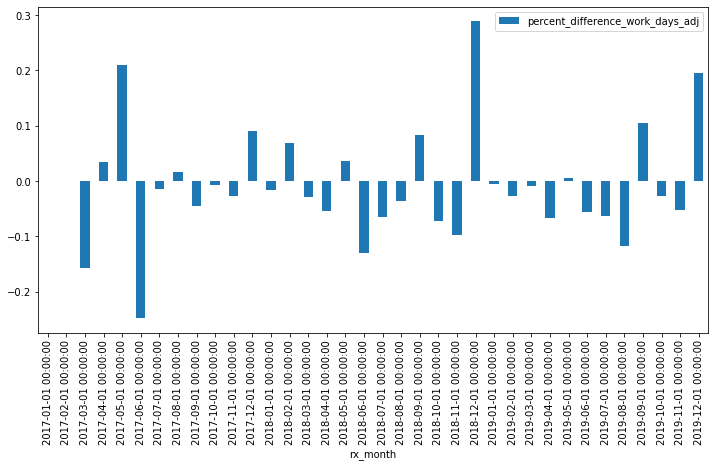

In [122]:
ax = ncso_sum_df.plot.bar(figsize = (12,6), x='rx_month', y='percent_difference_work_days_adj')

In [27]:
ax = ncso_sum_df.plot.bar(figsize = (12,6), y=['perc_difference', 'perc_difference_rolling', 'percent_difference_work_days_adj'])
ax.xaxis.set_major_formatter(plt.FixedFormatter(ncso_sum_df['rx_month'].dt.strftime("%b %Y"))) #this formats date as string in desired format for x axis, formats here: https://www.ibm.com/support/knowledgecenter/SS6V3G_5.3.1/com.ibm.help.gswapplintug.doc/GSW_strdate.html
ax.yaxis.set_major_formatter(ticker.PercentFormatter(1, decimals=None)) ##sets y axis labels as percent (and formats correctly i.e. x100)
#ax.set_title('Percentage difference between forecasted price concession costs, \nrolling 3 month average forecast and actual spend')
#ax.legend(["Single month forecast", "Rolling 3 month forecast"])

KeyError: "['percent_difference_work_days_adj'] not in index"

In [125]:
ncso_sum_df.head(25)

,rx_month,quantity,rolling_ave_quantity,predicted_cost,predicted_cost_rolling,actual_cost,difference,perc_difference,difference_rolling,perc_difference_rolling,year,mon,bdays0,bdays,bdays2,predicted_cost_work_days_adj,difference_adj,difference_work_day_adj,percent_difference_work_days_adj
0,2017-01-01,34903814,3.580363e+07,8.151401e+06,8.049272e+06,8.008703e+06,1.426981e+05,0.017818,4.056951e+04,0.005066,2017,1,21,20,NaN,NaN,NaN,NaN,NaN
1,2017-02-01,32129651,3.424974e+07,8.397418e+06,8.104830e+06,7.433894e+06,9.635236e+05,0.129612,6.709353e+05,0.090254,2017,2,19,19,NaN,NaN,NaN,NaN,NaN
2,2017-03-01,35701169,3.324040e+07,8.078590e+06,8.310292e+06,8.723591e+06,-6.450013e+05,-0.073938,-4.132996e+05,-0.047377,2017,3,22,22,20.0,7.344173e+06,-1.379419e+06,-1.379419e+06,-0.158125
3,2017-04-01,31360938,3.252794e+07,6.176515e+06,6.621021e+06,6.300387e+06,-1.238728e+05,-0.019661,3.206338e+05,0.050891,2017,4,20,18,19.0,6.519654e+06,2.192669e+05,2.192669e+05,0.034802
4,2017-05-01,34668969,3.425155e+07,1.361543e+07,1.263800e+07,1.238387e+07,1.231558e+06,0.099449,2.541320e+05,0.020521,2017,5,22,20,22.0,1.497697e+07,2.593101e+06,2.593101e+06,0.209393
5,2017-06-01,39153931,3.693957e+07,2.858565e+07,2.993281e+07,3.257050e+07,-3.984846e+06,-0.122345,-2.637690e+06,-0.080984,2017,6,21,21,18.0,2.450199e+07,-8.068511e+06,-8.068511e+06,-0.247725
6,2017-07-01,44127391,4.466837e+07,3.520778e+07,3.466878e+07,3.570354e+07,-4.957595e+05,-0.013885,-1.034757e+06,-0.028982,2017,7,20,20,20.0,3.520778e+07,-4.957595e+05,-4.957595e+05,-0.013885
7,2017-08-01,109038306,1.071921e+08,4.732995e+07,4.481809e+07,4.659972e+07,7.302289e+05,0.015670,-1.781633e+06,-0.038233,2017,8,22,21,21.0,4.732995e+07,7.302289e+05,7.302289e+05,0.015670
8,2017-09-01,270715011,2.700915e+08,5.839371e+07,5.900726e+07,5.823806e+07,1.556503e+05,0.002673,7.691957e+05,0.013208,2017,9,21,21,20.0,5.561306e+07,-2.625003e+06,-2.625003e+06,-0.045074
9,2017-10-01,403633528,4.001768e+08,7.105413e+07,7.138988e+07,7.154741e+07,-4.932872e+05,-0.006895,-1.575319e+05,-0.002202,2017,10,21,21,21.0,7.105413e+07,-4.932872e+05,-4.932872e+05,-0.006895


In [34]:
result.describe()

,quantity,rolling_ave_quantity,predicted_cost,predicted_cost_rolling,actual_cost,difference,perc_difference,difference_rolling,perc_difference_rolling,year,mon,bdays0,bdays,bdays2,predicted_cost_adj,difference_adj,percent_difference_adj
count,3.600000e+01,3.600000e+01,3.600000e+01,3.600000e+01,3.600000e+01,3.600000e+01,36.000000,3.600000e+01,36.000000,36.000000,36.00000,36.000000,36.000000,34.000000,3.400000e+01,3.400000e+01,34.000000
mean,1.650621e+08,1.652281e+08,2.436808e+07,2.436468e+07,2.460322e+07,-2.351389e+05,-0.006644,-2.385368e+05,-0.006818,2018.000000,6.50000,21.000000,20.333333,20.352941,2.539443e+07,-2.018363e+05,-0.008580
std,1.090658e+08,1.087582e+08,1.554031e+07,1.555434e+07,1.567256e+07,1.027457e+06,0.048385,9.098958e+05,0.038622,0.828079,3.50102,0.956183,1.095445,1.097721,1.570388e+07,2.758378e+06,0.104042
min,3.136094e+07,3.252794e+07,6.176515e+06,6.621021e+06,6.300387e+06,-3.984846e+06,-0.122345,-2.637690e+06,-0.080984,2017.000000,1.00000,19.000000,18.000000,18.000000,6.519654e+06,-8.068511e+06,-0.247725
25%,9.745254e+07,9.699663e+07,1.329558e+07,1.272012e+07,1.307452e+07,-5.769702e+05,-0.031024,-7.889908e+05,-0.038682,2017.000000,3.75000,20.000000,19.750000,20.000000,1.472777e+07,-1.337229e+06,-0.062244
50%,1.341943e+08,1.349755e+08,1.814484e+07,1.788253e+07,1.858640e+07,-2.599070e+05,-0.011448,-2.841992e+05,-0.012100,2018.000000,6.50000,21.000000,21.000000,21.000000,1.928529e+07,-5.336296e+05,-0.026933
75%,2.313135e+08,2.348814e+08,3.329990e+07,3.355665e+07,3.367090e+07,2.387476e+05,0.018082,2.707575e+05,0.015036,2019.000000,9.25000,22.000000,21.000000,21.000000,3.286069e+07,4.849511e+05,0.030019
max,4.153256e+08,4.103918e+08,7.105413e+07,7.138988e+07,7.154741e+07,1.958660e+06,0.129612,2.543399e+06,0.090254,2019.000000,12.00000,22.000000,22.000000,22.000000,7.105413e+07,1.038908e+07,0.288760
